# How do starspot contrasts vary with stellar effective temperature in the Gaia $G$ bandpass?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import astropy.units as u

from astropy.modeling.blackbody import blackbody_lambda

Use starspot properties from Table 5 of [Berdyugina 2005](http://adsabs.harvard.edu/abs/2005LRSP....2....8B): 

In [4]:
table5 = ascii.read('data/berdyugina2005.csv')

Use the $G$ band transmittance curve from Figure 3 of [Jordi et al. 2010](https://arxiv.org/abs/1008.0815), accessed via the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=GAIA/GAIA0.G&&mode=browse&gname=GAIA&gname2=GAIA0#filter):

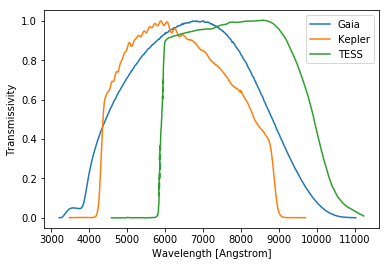

In [5]:
gaia_wl, gaia_transmissivity = np.loadtxt('data/gaiagband_svo.txt', unpack=True)
gaia_wl *= u.Angstrom

kepler_wl, kepler_transmissivity = np.loadtxt('data/keplerband_svo.txt', unpack=True)
kepler_wl *= u.Angstrom

tess_wl, tess_transmissivity = np.loadtxt('data/tess.csv', delimiter=',', unpack=True)
tess_wl *= u.nm
tess_wl = tess_wl.to(u.Angstrom)

plt.plot(gaia_wl, gaia_transmissivity, label='Gaia')
plt.plot(kepler_wl, kepler_transmissivity/kepler_transmissivity.max(), label='Kepler')
plt.plot(tess_wl, tess_transmissivity, label='TESS')

plt.legend()
plt.gca().set(xlabel='Wavelength [Angstrom]', ylabel='Transmissivity');

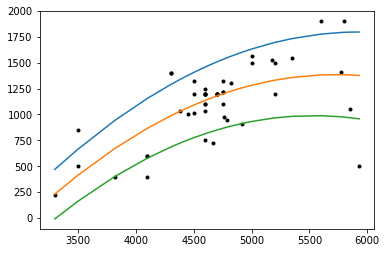

In [6]:
#plt.plot(table5['Teff K'], table5['deltaT K'], 'k.')

weighted_sunspot_temp_diff = (5770-5000)/5 + (5770-4200)*4/5

x = np.concatenate([table5['Teff K'].data.data, [5770]])
y = np.concatenate([table5['deltaT K'].data.data, [weighted_sunspot_temp_diff]]) 

x = x[y != 0]
y = y[y != 0]

yerr = 300 * np.ones_like(x)
yerr[-1] = 100

plt.plot(x, y, 'k.')

p, V = np.polyfit(x, y, 2, cov=True, w=1/yerr)
y_fit = np.polyval(p, x)

a0_err = np.sqrt(V[0, 0])
a1_err = np.sqrt(V[1, 1])
a2_err = np.sqrt(V[2, 2])

sort = np.argsort(x)
p_plus = p + np.array([a0_err, a1_err, a2_err])/20
p_minus = p - np.array([a0_err, a1_err, a2_err])/20
y_fit_plus = np.polyval(p_plus, x)
y_fit_minus = np.polyval(p_minus, x)

fit_params = [p_plus, p, p_minus]

x_range = np.linspace(x.min(), x.max(), 100)
np.savetxt('data/spot_temp_contrast.txt', 
           np.vstack([x_range, np.polyval(p, x_range)]).T)

plt.plot(x[sort], y_fit_plus[sort])
plt.plot(x[sort], y_fit[sort])
plt.plot(x[sort], y_fit_minus[sort])

plt.show()

Plot the spot and photosphere temperatures, along with the spot contrasts integrated in the Gaia bandpass. 

In [7]:
# Source: http://www.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html
effective_temperatures = {
 'G0': 6050,
 'G1': 5930,
 'G2': 5800,
 'G5': 5660,
 'G8': 5440,
 'K0': 5240,
 'K1': 5110,
 'K2': 4960,
 'K3': 4800,
 'K4': 4600,
 'K5': 4400,
 'K7': 4000,
 'M0': 3750,
 'M1': 3700,
 'M2': 3600,
 'M3': 3500,
 'M4': 3400,
 'M5': 3200,
 'M6': 3100,
 'M7': 2900,
 'M8': 2700}

In [8]:
len(x)

47

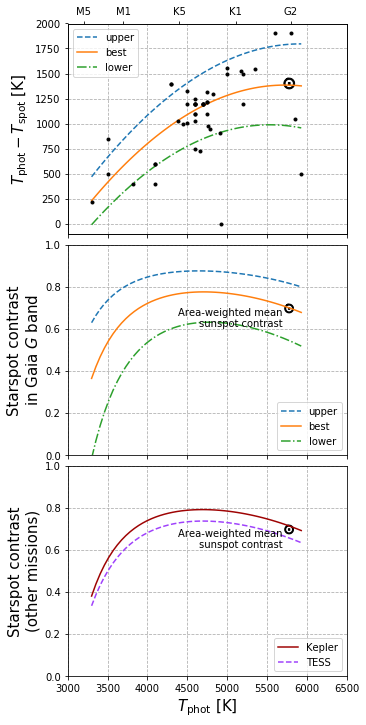

In [9]:
fontsize = 15

temp_phots = np.linspace(x.min(), x.max(), 50)

labels = ['upper', 'best', 'lower']
linestyles = ['--', '-', '-.']
teff_bounds = [3000, 6500]

fig, ax = plt.subplots(3, 1, figsize=(5, 12))

for fit_p, ls, label in zip(fit_params, linestyles, labels):
    
    get_temp_diff = lambda tphot: np.polyval(fit_p, tphot)
    ax[0].plot(temp_phots, get_temp_diff(temp_phots), label=label, ls=ls, lw=1.5)

    gaia_contrasts = []
    for temp in temp_phots: 
        phot_irr = blackbody_lambda(gaia_wl, temp)
        spot_temp = temp - get_temp_diff(temp)
        spot_irr = blackbody_lambda(gaia_wl, spot_temp)

        contrast = (1 - np.trapz(spot_irr*gaia_transmissivity*gaia_wl) / 
                    np.trapz(phot_irr*gaia_transmissivity*gaia_wl))
        gaia_contrasts.append(contrast)

    ax[1].plot(temp_phots, gaia_contrasts, ls=ls, lw=1.5, label=label)
    
    if label == 'best':
        kepler_contrasts = []
        for temp in temp_phots: 
            phot_irr = blackbody_lambda(kepler_wl, temp)
            spot_temp = temp - get_temp_diff(temp)
            spot_irr = blackbody_lambda(kepler_wl, spot_temp)

            contrast = (1 - np.trapz(spot_irr*kepler_transmissivity*kepler_wl) / 
                        np.trapz(phot_irr*kepler_transmissivity*kepler_wl))
            kepler_contrasts.append(contrast)

        ax[2].plot(temp_phots, kepler_contrasts, ls=ls, 
                   lw=1.5, label='Kepler', color='#9e0303')

        tess_contrasts = []
        for temp in temp_phots: 
            phot_irr = blackbody_lambda(tess_wl, temp)
            spot_temp = temp - get_temp_diff(temp)
            spot_irr = blackbody_lambda(tess_wl, spot_temp)

            contrast = (1 - np.trapz(spot_irr*tess_transmissivity*tess_wl) / 
                        np.trapz(phot_irr*tess_transmissivity*tess_wl))
            tess_contrasts.append(contrast)

        ax[2].plot(temp_phots, tess_contrasts, ls='--', 
                   lw=1.5, label='TESS', color='#9f41fc')
    
    
ax[0].legend(loc='upper left')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')


ax[0].plot(table5['Teff K'], table5['deltaT K'], 'k.')

ax0_upper = ax[0].twiny()
label_sptypes = ['M5', 'M1', 'K5', 'K1', 'G2']
label_teffs = [effective_temperatures[l] for l in label_sptypes]
ax0_upper.set_xlim(teff_bounds)
ax0_upper.set_xticks(label_teffs)
ax0_upper.set_xticklabels(label_sptypes)

sunspot_contrasts = []

for temp_diff, temp_phot, label in zip([5770-5000, 5770-4200], 
                                       [5770, 5770],
                                       ['umbra', 'penumbra']):

    phot_irr = blackbody_lambda(gaia_wl, temp_phot)
    spot_temp = temp_phot - temp_diff
    spot_irr = blackbody_lambda(gaia_wl, spot_temp)

    contrast = (1 - np.trapz(spot_irr*gaia_transmissivity*gaia_wl) / 
                np.trapz(phot_irr*gaia_transmissivity*gaia_wl))
    sunspot_contrasts.append(contrast.value)

    
ax[0].scatter(temp_phot, weighted_sunspot_temp_diff, 
              color='k', marker='$\odot$', 
              label='sun', s=150)
    
area_weighted_sunspot_contrast = np.dot(sunspot_contrasts, [1/5, 4/5])

ax[1].set_ylabel('Starspot contrast\nin Gaia $G$ band', fontsize=fontsize)
ax[2].set_ylabel('Starspot contrast\n(other missions)', fontsize=fontsize)
ax[-1].set_xlabel("$T_{\mathrm{phot}}$ [K]", fontsize=fontsize)
ax[0].set_ylabel("$T_{\mathrm{phot}} - T_{\mathrm{spot}}$ [K]", 
                 fontsize=fontsize)

for i in range(2):
    ax[i].set_xticklabels([])

for i in range(1, 3):
    ax[i].set_xticks(ax[0].get_xticks())
    ax[i].set_ylim([0, 1])
    ax[i].scatter(5770, area_weighted_sunspot_contrast, color='k', marker='$\odot$', 
                  label='sun', s=100)
    ax[i].annotate("Area-weighted mean\nsunspot contrast", xy=(5700, 0.6), #xy=(5700, 0.72), 
                   va='bottom', ha='right', color='k')

for axis in ax:
    axis.grid(ls='--')
    axis.set_xlim(teff_bounds)

fig.subplots_adjust(hspace=0.05)
fig.savefig('contrasts.pdf', bbox_inches='tight')

*Upper*: The spot temperature contrasts scale quadratically with photosphere effective temperatures. The mean, area-weighted sunspot contrast is labeled $\odot$ (including both the umbra and penumbra).

*Lower*: Spot flux contrasts, approximated by integrating blackbody radiance curves with the temperatures of the photosphere and spot, convolved with the Gaia $G$ bandpass. The area-weighted mean sunspot contrast is 0.7, marked with $\odot$. 